In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns

In [2]:
import os

if os.environ.get('USER') == 'acganesh':
    base = './metrics'
    df_cifar_all = pd.read_csv(f"{base}/latest/060221-234441_CIFAR10_metrics.csv")
    df_stl_all = pd.read_csv(f"{base}/latest/060221-235053_STL10_metrics.csv")
    df_svhn_all = pd.read_csv(f"{base}/latest/060321-001129_SVHN_metrics.csv")
    df_cifar_limited = pd.read_csv(f"{base}/fewshot/060321-015613_CIFAR10_metrics.csv")
    df_stl_limited = pd.read_csv(f"{base}/fewshot/060321-020115_STL10_metrics.csv")
    df_svhn_limited = pd.read_csv(f"{base}/fewshot/060321-020423_SVHN_metrics.csv")

else:
    df_cifar_all = pd.read_csv("../../REALRESULTS/060221-234441_CIFAR10_metrics.csv")
    df_stl_all = pd.read_csv("../../REALRESULTS/060221-235053_STL10_metrics.csv")
    df_svhn_all = pd.read_csv("../../REALRESULTS/060321-001129_SVHN_metrics.csv")
    df_cifar_limited = pd.read_csv("../../REALRESULTS/FEW Shot/060321-015613_CIFAR10_metrics.csv")
    df_stl_limited = pd.read_csv("../../REALRESULTS/FEW Shot/060321-020115_STL10_metrics.csv")
    df_svhn_limited = pd.read_csv("../../REALRESULTS/FEW Shot/060321-020423_SVHN_metrics.csv")

In [3]:
sample_types = np.array(['rand', 'kmeans', 'loss_based_mean', 'loss_based_std',
       'grad_based_mean', 'grad_based_std'])

percentages = 100 * np.array([0.0025, 0.005, 0.0075, 0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.5, 0.75, 1])
num_examples = np.arange(5, 99)

In [4]:
sample_dict = {'rand':'Random', 
                'kmeans':'KMeans', 
                'loss_based_mean':'LossMean', 
                'loss_based_std':'LossVar',
                'grad_based_mean':'GradMean', 
                'grad_based_std':'GradVar',
               }

In [5]:
def select_examples(df1, df2, num_examples_1, num_examples_2):
    df1_masked = df1[df1["num_examples"].isin(num_examples_1)]
    df2_masked = df2[df2["num_examples"].isin(num_examples_2)]
    df_final = pd.concat([df1_masked,df2_masked])
    return df_final

In [6]:
df_cifar = select_examples(df_cifar_limited, df_cifar_all, np.logspace(0.69, 2, 25, dtype=int), np.array([137, 275, 412, 550, 687, 1375]))
df_stl = select_examples(df_stl_limited, df_stl_all, np.logspace(0.69, 2, 25, dtype=int), np.array([250, 500, 750, 1000, 1250, 2500, 3750]))
df_svhn = select_examples(df_svhn_limited, df_svhn_all, np.logspace(0.69, 2, 25, dtype=int), np.array([500,1000, 1500, 2000, 2500, 5000, 7500]))

In [7]:
# Mask 1 is which sample_types you want from df 1
def merge_dfs(df1, df2, mask_1):
    mask = np.array(mask_1)
    df1_masked = df1[df1["sampler_type"].isin(mask)]
    df2_masked = df2[~df2["sampler_type"].isin(mask)]
    df_final = pd.concat([df1_masked,df2_masked])
    return df_final
    

In [8]:
def get_rankings(scores, num, num_examples): # first num percentages to rank
    total_rankings = defaultdict(int)
    for index, percentage in enumerate(num_examples[:num]):
        names = sorted(scores.items(), key=lambda item: item[1][index], reverse=True)
        ranking = [names[0][0], names[1][0], names[2][0], names[3][0], names[4][0], names[5][0]]
        
        for rank, name in enumerate(ranking):
            total_rankings[name] = total_rankings[name] + (rank + 1)
        
    for key, value in total_rankings.items():
        print(key, value / num) # divide by total
        


def plot_metrics(df_full, ds, num_to_rank=50):
    df = df_full.groupby(["ds_type", "sampler_type", "num_examples"]).mean().reset_index()
    plt.figure(figsize=(8,5))
    scores = {}
    for sample_type in df["sampler_type"].unique():
        num_examples = df[df.sampler_type == sample_type]["num_examples"].tolist()
        lr_acc = df[df.sampler_type == sample_type]["lr_byol_acc"].tolist()
        scores[sample_type] = lr_acc
        sns.scatterplot(num_examples, lr_acc, label=sample_dict[sample_type])

    get_rankings(scores, num_to_rank, num_examples)
        
    plt.legend()
#     plt.xticks(np.arange(len(percentages)), percentages)
    plt.xscale("log")
    plt.xlabel("Number of Labels Used")
    plt.ylabel("Accuracy")
    plt.title("Top-1 Accuracy: {}".format(ds), fontsize=14)
    plt.show()
    
    scores = {}
    plt.figure()
    for sample_type in df["sampler_type"].unique():
        num_examples = df[df.sampler_type == sample_type]["num_examples"].tolist()
        lr_acc = df[df.sampler_type == sample_type]["lr_byol_top3_acc"].tolist()
        scores[sample_type] = lr_acc
        plt.scatter(num_examples, lr_acc, label=sample_type)

    get_rankings(scores, num_to_rank, num_examples)
    
    plt.legend()
    plt.xscale("log")
#     plt.xticks(np.arange(len(percentages)), percentages)
    plt.title("Top-3 Acc {}".format(ds))
    plt.show()

/Users/acganesh/miniforge3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/acganesh/miniforge3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/acganesh/miniforge3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  w

grad_based_mean 2.06
grad_based_std 1.9
loss_based_mean 3.32
loss_based_std 1.54
kmeans 1.7
rand 1.66


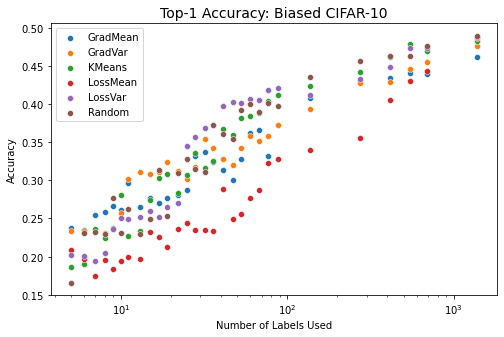

grad_based_mean 2.14
grad_based_std 1.74
loss_based_mean 3.24
kmeans 1.56
loss_based_std 2.1
rand 1.4


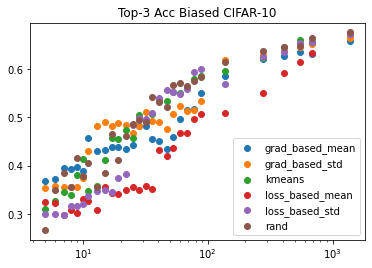

In [9]:
plot_metrics(df_cifar, "Biased CIFAR-10")

/Users/acganesh/miniforge3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/acganesh/miniforge3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/acganesh/miniforge3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  w

grad_based_mean 2.28
loss_based_std 1.68
rand 1.54
loss_based_mean 2.82
kmeans 1.68
grad_based_std 2.6


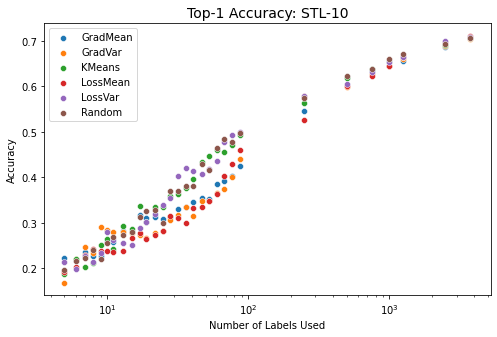

grad_based_mean 3.0
kmeans 1.64
rand 1.32
loss_based_std 2.16
grad_based_std 2.08
loss_based_mean 2.4


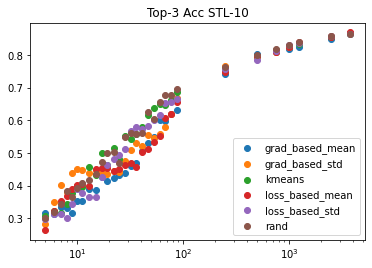

In [10]:
plot_metrics(df_stl, "STL-10")

/Users/acganesh/miniforge3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/acganesh/miniforge3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/acganesh/miniforge3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  w

loss_based_std 1.48
grad_based_mean 1.62
kmeans 2.26
rand 1.92
loss_based_mean 2.82
grad_based_std 2.5


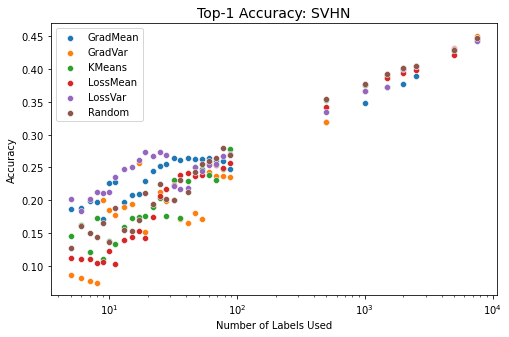

grad_based_mean 1.88
loss_based_std 1.46
kmeans 2.16
rand 1.66
grad_based_std 2.58
loss_based_mean 2.86


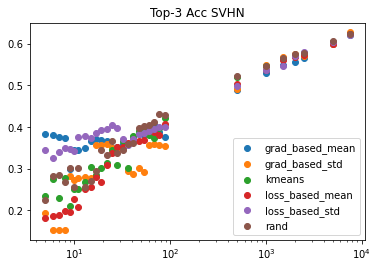

In [11]:
plot_metrics(df_svhn, "SVHN")

In [13]:
df_cifar_limited

,lr_byol_acc,lr_byol_top3_acc,sampler_type,ds_type,num_examples
0,0.145636,0.200000,rand,CIFAR10,5
1,0.231091,0.290909,rand,CIFAR10,6
2,0.281636,0.429455,rand,CIFAR10,7
3,0.238182,0.347818,rand,CIFAR10,8
4,0.293455,0.480182,rand,CIFAR10,9
...,...,...,...,...,...
1316,0.378909,0.528000,grad_based_std,CIFAR10,96
1317,0.368727,0.551273,grad_based_mean,CIFAR10,97
1318,0.380545,0.532545,grad_based_std,CIFAR10,97
1319,0.371818,0.553273,grad_based_mean,CIFAR10,98


In [18]:
mask = [10, 100, 500, 1000, 1375]
df_cifar.loc[df_cifar['num_examples'].isin(mask)]

,lr_byol_acc,lr_byol_top3_acc,sampler_type,ds_type,num_examples
5,0.286000,0.445636,rand,CIFAR10,10
100,0.303273,0.466000,kmeans,CIFAR10,10
194,0.233091,0.402000,rand,CIFAR10,10
289,0.238727,0.379818,kmeans,CIFAR10,10
383,0.225091,0.341636,rand,CIFAR10,10
478,0.242727,0.311273,kmeans,CIFAR10,10
572,0.167636,0.305636,rand,CIFAR10,10
667,0.279455,0.437636,kmeans,CIFAR10,10
761,0.240364,0.397091,rand,CIFAR10,10
856,0.337636,0.478000,kmeans,CIFAR10,10


In [21]:
set(df_cifar['num_examples'])

{5,
 6,
 7,
 8,
 9,
 10,
 11,
 13,
 15,
 17,
 19,
 22,
 25,
 28,
 32,
 36,
 41,
 47,
 53,
 60,
 68,
 77,
 88,
 137,
 275,
 412,
 550,
 687,
 1375}

In [72]:
mask = [20, 137, 550, 1375, 2750]
res = df_cifar_all[df_cifar_all['num_examples'].isin(mask)]

#print(res.to_string())

res = res.groupby(["ds_type", "sampler_type", "num_examples"]).mean().reset_index()
res = res.sort_values(['num_examples', 'sampler_type'], ascending=(True, False))
res = res.round(3)
print(res.to_latex(index=False))

\begin{tabular}{llrrr}
\toprule
ds\_type &    sampler\_type &  num\_examples &  lr\_byol\_acc &  lr\_byol\_top3\_acc \\
\midrule
CIFAR10 &            rand &            20 &        0.329 &             0.504 \\
CIFAR10 &  loss\_based\_std &            20 &        0.323 &             0.480 \\
CIFAR10 & loss\_based\_mean &            20 &        0.227 &             0.367 \\
CIFAR10 &          kmeans &            20 &        0.284 &             0.436 \\
CIFAR10 &  grad\_based\_std &            20 &        0.342 &             0.482 \\
CIFAR10 & grad\_based\_mean &            20 &        0.222 &             0.334 \\
CIFAR10 &            rand &           137 &        0.436 &             0.615 \\
CIFAR10 &  loss\_based\_std &           137 &        0.412 &             0.569 \\
CIFAR10 & loss\_based\_mean &           137 &        0.340 &             0.510 \\
CIFAR10 &          kmeans &           137 &        0.424 &             0.597 \\
CIFAR10 &  grad\_based\_std &           137 &        0.393 

In [74]:
mask = [100, 500, 2000, 5000, 10000]

res = df_svhn_all[df_svhn_all['num_examples'].isin(mask)]

res = res.groupby(["ds_type", "sampler_type", "num_examples"]).mean().reset_index()
res = res.sort_values(['num_examples', 'sampler_type'], ascending=(True, False))
res = res.round(3)
#print(res.to_string())
print(res.to_latex(index=False))

\begin{tabular}{llrrr}
\toprule
ds\_type &    sampler\_type &  num\_examples &  lr\_byol\_acc &  lr\_byol\_top3\_acc \\
\midrule
   SVHN &            rand &           100 &        0.274 &             0.431 \\
   SVHN &  loss\_based\_std &           100 &        0.268 &             0.408 \\
   SVHN & loss\_based\_mean &           100 &        0.255 &             0.397 \\
   SVHN &          kmeans &           100 &        0.265 &             0.416 \\
   SVHN &  grad\_based\_std &           100 &        0.250 &             0.414 \\
   SVHN & grad\_based\_mean &           100 &        0.263 &             0.406 \\
   SVHN &            rand &           500 &        0.354 &             0.522 \\
   SVHN &  loss\_based\_std &           500 &        0.334 &             0.498 \\
   SVHN & loss\_based\_mean &           500 &        0.342 &             0.503 \\
   SVHN &          kmeans &           500 &        0.352 &             0.521 \\
   SVHN &  grad\_based\_std &           500 &        0.319 

In [75]:
mask = [50, 500, 1000, 2500, 5000]
set(df_stl_all['num_examples'])

res = df_stl_all[df_stl_all['num_examples'].isin(mask)]
res = res.groupby(["ds_type", "sampler_type", "num_examples"]).mean().reset_index()
res = res.sort_values(['num_examples', 'sampler_type'], ascending=(True, False))
res = res.round(3)
#print(res.to_string(index=False))

print(res.to_latex(index=False))

\begin{tabular}{llrrr}
\toprule
ds\_type &    sampler\_type &  num\_examples &  lr\_byol\_acc &  lr\_byol\_top3\_acc \\
\midrule
  STL10 &            rand &            50 &        0.417 &             0.624 \\
  STL10 &  loss\_based\_std &            50 &        0.444 &             0.619 \\
  STL10 & loss\_based\_mean &            50 &        0.306 &             0.493 \\
  STL10 &          kmeans &            50 &        0.415 &             0.598 \\
  STL10 &  grad\_based\_std &            50 &        0.400 &             0.593 \\
  STL10 & grad\_based\_mean &            50 &        0.445 &             0.659 \\
  STL10 &            rand &           500 &        0.623 &             0.801 \\
  STL10 &  loss\_based\_std &           500 &        0.605 &             0.784 \\
  STL10 & loss\_based\_mean &           500 &        0.601 &             0.796 \\
  STL10 &          kmeans &           500 &        0.618 &             0.796 \\
  STL10 &  grad\_based\_std &           500 &        0.598 

In [63]:
pd.set_option("display.precision", 8)